In [1]:
import matplotlib.pyplot as plt
import contextily as cx
import os
import glob
import re
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import rasterio

In [2]:
root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [3]:
# Convert tiff to aray
def tiff_to_array_rasterio(file_path):
    # Open the TIFF file
    with rasterio.open(file_path) as src:
        # Read the image data
        img_array = src.read()
        # Optionally, you may want to read metadata
        meta = src.meta
        xmin, ymin, xmax, ymax = src.bounds

    
    return img_array, meta, xmin, ymin, xmax, ymax

In [4]:
tifs = glob.glob(root + '/data/FNR/*.tif')

In [5]:
fnr_array, meta, xmin, ymin, xmax, ymax = tiff_to_array_rasterio(tifs[0])

In [6]:
# Convert tif into grids shapefile
import geopandas as gpd
from shapely.geometry import box

idx, rows, cols = fnr_array.shape
x_res = (xmax - xmin) / cols
y_res = (ymax - ymin) / rows

# Create polygons from the grid cells
polygons = []
for i in range(rows):
    for j in range(cols):
        x = xmin + j * x_res
        y = ymax - (i + 1) * y_res
        polygons.append({
            'geometry': box(x, y, x + x_res, y - y_res),
            'value': fnr_array[0, i, j]  # Assuming the raster has values associated with each cell
        })
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(polygons)

# Assign CRS to the GeoDataFrame
gdf.crs = 'EPSG:4326'

In [7]:
# Define custom colormap
## We plotted FNR from 0 to 8. 2.2 to 3.7 is considered as transition zone (cyan) - 
## equivalent values on 0-1 scale are 0.275 and 0.4625
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, '#70db7e'), #lightgreen
          (0.27, '#305e35'), #darkgreen
          (0.275, '#00ced1'), #cyan
          (0.4625, '#0a9396'), #darkcyan
          (0.47, '#f7f02d'), #yellow
          (0.75, '#F77F00'), #orange
          (1, '#720026') #brown
         ]  # Define color points: (position, color)
cmap_name = 'custom_cmap'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

In [8]:
cx.providers.keys()

dict_keys(['OpenStreetMap', 'MapTilesAPI', 'OpenSeaMap', 'OPNVKarte', 'OpenTopoMap', 'OpenRailwayMap', 'OpenFireMap', 'SafeCast', 'Stadia', 'Thunderforest', 'CyclOSM', 'Jawg', 'MapBox', 'MapTiler', 'Stamen', 'TomTom', 'Esri', 'OpenWeatherMap', 'HERE', 'HEREv3', 'FreeMapSK', 'MtbMap', 'CartoDB', 'HikeBike', 'BasemapAT', 'nlmaps', 'NASAGIBS', 'NLS', 'JusticeMap', 'GeoportailFrance', 'OneMapSG', 'USGS', 'WaymarkedTrails', 'OpenAIP', 'OpenSnowMap', 'AzureMaps', 'SwissFederalGeoportal', 'Gaode', 'Strava'])

In [9]:
cx.providers.OpenStreetMap.keys()

dict_keys(['Mapnik', 'DE', 'CH', 'France', 'HOT', 'BZH', 'BlackAndWhite'])

In [10]:
# To overlay Delhi roads
roads = gpd.read_file(root+ '/assets/grids_delhi_primary.shp')

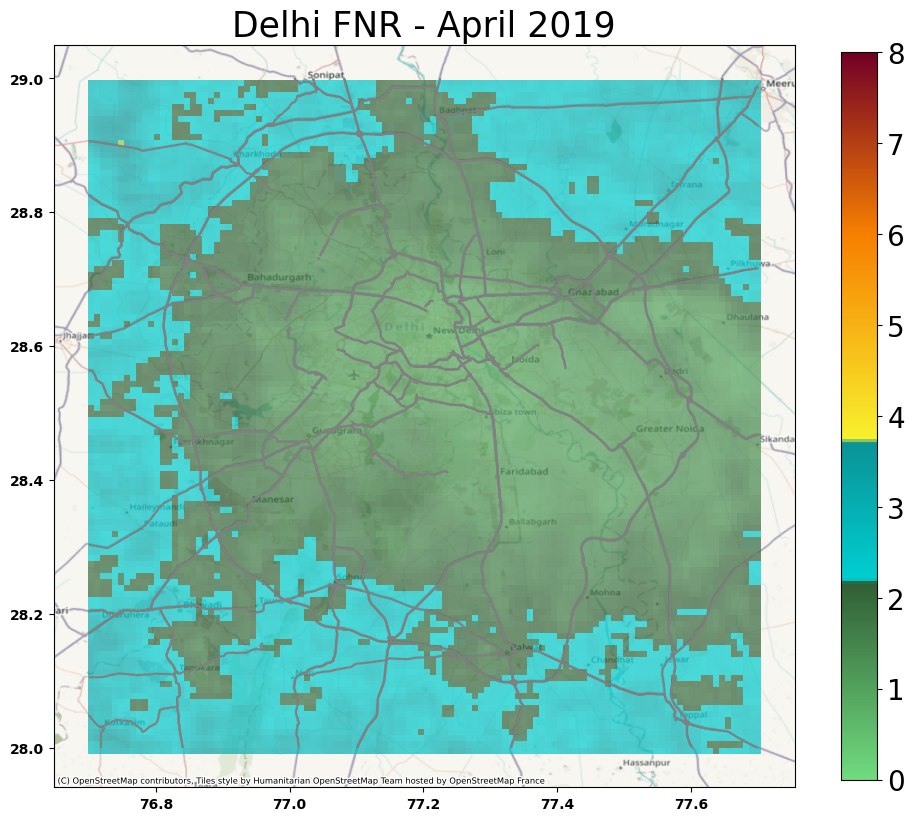

In [34]:
import matplotlib.pyplot as plt
import contextily as cx

## Plot grids_masked for the masked map
gdf_wm = gdf.to_crs(epsg=4326)
ax = gdf_wm.plot(figsize=(10, 10),
              column='value',
              alpha=0.7, #Transparency
              legend=True,
                 legend_kwds={'shrink': 0.75},
              cmap=custom_cmap,
              vmin=0,
              vmax=8
             )
roads.plot(ax=ax, color='gray')
plt.title('Delhi FNR - April 2019', fontsize=25)
plt.xticks(fontweight='bold', fontsize=10)
plt.yticks(fontweight='bold', fontsize=10)
fig = ax.figure
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=20)

cx.add_basemap(ax, crs=gdf_wm.crs.to_string(), attribution_size=6)
plt.tight_layout()
plt.savefig('FNR_sample.png', dpi=600)

In [15]:
from datetime import datetime

def month_to_number(month_name):
    """
    Convert three-letter month name to its corresponding zero-padded number.
    """
    datetime_object = datetime.strptime(month_name, "%b")
    month_number = datetime_object.month
    return f"{month_number:02d}"  # Format the month number as zero-padded string


# Example usage:
month_name = 'Feb'
month_number = month_to_number(month_name)
print(month_number)  # Output: 2


02


In [21]:
#Mass production
from tqdm import tqdm
for tif in tqdm(tifs):
    f = tif.split('\\')[-1].split('_')
    f.remove('FNR')
    f.remove('CF50.tif')
    title = 'Delhi FNR - '+' '.join(f)

    if (len(f)==2) & (f[1]!='Winter'):
        month_number = month_to_number(f[1])
        year=f[0]
    else:
        year=f[0]
        month_number = ''.join(f[1:])

    fnr_array, meta, xmin, ymin, xmax, ymax = tiff_to_array_rasterio(tif)

    # Convert tif into grids shapefile
    import geopandas as gpd
    from shapely.geometry import box
    
    idx, rows, cols = fnr_array.shape
    x_res = (xmax - xmin) / cols
    y_res = (ymax - ymin) / rows
    
    # Create polygons from the grid cells
    polygons = []
    for i in range(rows):
        for j in range(cols):
            x = xmin + j * x_res
            y = ymax - (i + 1) * y_res
            polygons.append({
                'geometry': box(x, y, x + x_res, y - y_res),
                'value': fnr_array[0, i, j]  # Assuming the raster has values associated with each cell
            })
    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(polygons)
    
    # Assign CRS to the GeoDataFrame
    gdf.crs = 'EPSG:4326'

    ## Plot grids_masked for the masked map
    gdf_wm = gdf.to_crs(epsg=4326)
    ax = gdf_wm.plot(figsize=(10, 10),
                  column='value',
                  alpha=0.7, #Transparency
                  legend=False,
                     legend_kwds={'shrink': 0.75},
                  cmap=custom_cmap,
                  vmin=0,
                  vmax=8
                 )
    roads.plot(ax=ax, color='gray')
    plt.title(title, fontsize=25)
    plt.xticks(fontweight='bold', fontsize=12)
    plt.yticks(fontweight='bold', fontsize=12)
    fig = ax.figure
    #cb_ax = fig.axes[1] 
    #cb_ax.tick_params(labelsize=15)
    
    cx.add_basemap(ax, crs='EPSG:4326',attribution_size=6)
    plt.tight_layout()
    plt.savefig(root+'/plots/FNRPlots/Delhi_FNR_{}-{}.png'.format(year,month_number), dpi=600)
    plt.close()

100%|██████████| 83/83 [14:22<00:00, 10.39s/it]


In [18]:
#Mass production
tifs = glob.glob('O3_tifs/*.tif')

# Define custom colormap
from matplotlib.colors import LinearSegmentedColormap
#colors = [(0, '#f7f02d'), (0.4, '#F77F00'), (0.7, '#720026'), (1, '#000000')]  # Define color points: (position, color)
#colors = [(0, '#70db7e'), (0.4, '#305e35'), (0.7, '#123524'), (1, '#000000')]
#colors = [(0, '#87ceeb'), (0.4, '#4166f5'), (0.7, '#191970'), (1, '#000000')]
colors = [(0, '#70db7e'), (0.166, '#305e35'), (0.333, '#00ced1'), (0.5, '#0a9396'), (0.666, '#f7f02d'),(0.833, '#F77F00'), (1, '#720026')]  # Define color points: (position, color)

cmap_name = 'custom_cmap'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

mins = []
maxs = []

from tqdm import tqdm
for tif in tqdm(tifs):
    f = tif.split('\\')[1].split('_')
    f.remove('CF50.tif')
    title = 'Delhi - '+' '.join(f)+' (mol/m2)'

    if (len(f)==3) & (f[2]!='Winter'):
        month_number = month_to_number(f[2])
        year=f[1]
    else:
        year=f[1]
        month_number = ''.join(f[2:])

    fnr_array, meta, xmin, ymin, xmax, ymax = tiff_to_array_rasterio(tif)
    mins.append(np.nanmin(fnr_array))
    maxs.append(np.nanmax(fnr_array))

    # Convert tif into grids shapefile
    import geopandas as gpd
    from shapely.geometry import box
    
    idx, rows, cols = fnr_array.shape
    x_res = (xmax - xmin) / cols
    y_res = (ymax - ymin) / rows
    
    # Create polygons from the grid cells
    polygons = []
    for i in range(rows):
        for j in range(cols):
            x = xmin + j * x_res
            y = ymax - (i + 1) * y_res
            polygons.append({
                'geometry': box(x, y, x + x_res, y - y_res),
                'value': fnr_array[0, i, j]  # Assuming the raster has values associated with each cell
            })
    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(polygons)
    
    # Assign CRS to the GeoDataFrame
    gdf.crs = 'EPSG:4326'

    ## Plot grids_masked for the masked map
    gdf_wm = gdf.to_crs(epsg=4326)
    ax = gdf_wm.plot(figsize=(10, 10),
                  column='value',
                  alpha=0.7, #Transparency
                  legend=True,
                     legend_kwds={'shrink': 0.75},
                  cmap=custom_cmap,
                  vmin=0.11,#0.11 for O3, 0 for others
                  vmax=0.14 #0.14 for O3, 0.0005 for others
                 )
    roads.plot(ax=ax, color='gray')
    plt.title(title, fontsize=20)
    plt.xticks(fontweight='bold', fontsize=10)
    plt.yticks(fontweight='bold', fontsize=10)
    fig = ax.figure
    cb_ax = fig.axes[1] 
    cb_ax.tick_params(labelsize=15)
    
    cx.add_basemap(ax, crs='EPSG:4326',attribution_size=6)
    plt.tight_layout()
    plt.savefig('O3Plots/Delhi_O3_{}-{}.png'.format(year,month_number), dpi=50)
    plt.close()

100%|██████████| 81/81 [04:45<00:00,  3.52s/it]


In [31]:
handles,labels = ax.get_legend_handles_labels()

In [32]:
ax.legend(handles, labels)

plt.savefig('legend.png')

<Figure size 640x480 with 0 Axes>